# Getting started
# MROB library is unfinished version of Mobile Robotics library. 
Please, don't publish this library anywhere. 

### MROB: Mobile Robotics library
The Skoltech Mobile Robotics library (mrob) is our common framework for implementing our robotics research and projects. It includes a core set of functionalities including perception, path planning and optimization. The present library is meant to be a self-contained library.

- common: common matrix definitions and typedefs.
- **SE3: Rigid Body Transformations library.**
- Fgraph: Factor Graph (WIP)
- PCReg: Point Cloud Registration (WIP)
- mrobPy Python bindings (using pybind11) for some of the above methods.

#### SE3 


 - **Constructors**:
    - Mat61,requires the Transformation in Se3
    - Mat4, requires the Transformation matrix 4x4, Lie algebra xi^ \in se3 representing the rigid body transformation around the identity, by default generates T = exp(0^) = I
    - SE3, allows to construct from Eigen expressions

  *Returns True is the matrix is a valid transformation and False if not*
 - **T()**, 4x4 Transformation matrix
 - **R()**, returns a matrix 3x3 of the SO3 rotation corresponding to the subblock matrix
 - **t()**, returns translation vector
 - **mul()**, multiplication function
 - **update_lhs()**, updates the current transformation incrementaly
 - **update_rhs()**,  exponential mapping of a skew symetric matrix in se3.
 - **ln()**, logarithm map, first we calculate ln(R) and then 
 
 V^-1 = I - 1/2 w^ + 1/o^2(1 - A / 2B) (w^)^2, $v = V^-1 t$ 

 Returns the vector $xi \in R^6$ which corresponds to the Lie algebra SE3
 - **transform()**, transforms a point $p = (x,y,z)'$ such as $res = T*p$. This function saves to transform to homogeneous coordinates.
 - **transform_array()**, transforms an array of points $P = {p_n} = (x,y,z)'_n$ such as $res = T*p_n$. The array is of the form $3xN$. This function saves to transform to homogeneous coordinates.
 - **inv()**, inverse: 
 $$
 T^-1 = \begin{vmatrix}
R'&-R't\\
0&1\\
\end{vmatrix}
$$
 - **adj()**, Adjoint: T Exp(x) = Exp ( Adj_T x) T
  $$
Adj_T  = \begin{vmatrix}
R & 0\\
t^R&R\\
\end{vmatrix}
$$
 - **distance()**,provide the distance as a norm on the tangent space of the $ln(T * T_{rhs}^{-1}) $
 - **print()**

## Import libraries

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.display import clear_output
path = 'mrob/lib'
import sys
sys.path.append(path)
import mrob
from scipy.spatial import distance

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])


In [2]:
points_dict = load_obj('data')

X = points_dict['X']
Y = points_dict['Y']
S = points_dict["S"]

## Task 1A

In [3]:
def plot_PC(Y, T, X):
    Y_ = T.transform_array(X.T).T    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Y[:,0], Y[:,1], Y[:,2], 'o', label='Pointcloud Y')
    ax.plot(Y_[:,0], Y_[:,1], Y_[:,2], 'o', label='Estimation Y_')
    for x,y,z,x_,y_,z_ in zip(Y[:,0],Y[:,1],Y[:,2],Y_[:,0],Y_[:,1],Y_[:,2]):
        ax.plot([x,x_],[y,y_],[z,z_],color = 'orange', linewidth = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.tight_layout()

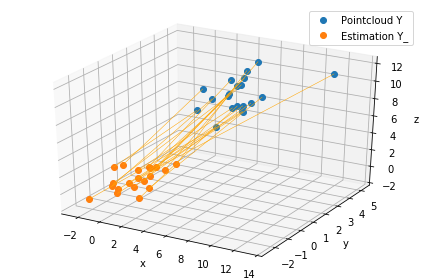

In [4]:
T = mrob.SE3(np.zeros(6))
plot_PC(Y,T,X)

## Task 1B

In [5]:
def C_t_current_value(X,T,S):
    R = T.transform_array(X.T) - Y.T
    error = 0
    for i in range(20):
        error += 1/2*(R[:,i].T @ np.linalg.inv(S[i]) @ R[:,i])
    return error

## Task 1C

In [6]:
def gradient(X,T,S):
    R = T.transform_array(X.T) - Y.T
    grad = np.zeros(6)
    for i in range(20):            
        r = R[:,i]
        rot = skew(T.transform(X[i]))
        grad_i = np.hstack( (-rot , np.eye(3)))
        grad = grad + r @ np.linalg.inv(S[i]) @ grad_i
    return grad

Let's check the magnitute of gradient:

In [7]:
np.linalg.norm(gradient(X,T,S))

6194333.93964086

Everything seems nice

## Task 1D

In [8]:
def update_T(T, grad):
    alpha = 1e-7*np.hstack((0.1*np.ones(3),np.ones(3))) #1e-6 causes dramatical increasing of error, decrease learning rate is the decision
    T.update_lhs(- alpha * grad)

In [9]:
T_test = mrob.SE3(np.zeros(6))
print('Error before: ', C_t_current_value(X, T_test, S))
update_T(T_test, gradient(X, T_test, S))
print('Error after: ', C_t_current_value(X, T_test, S))

Error before:  10994762.233795457
Error after:  9795336.056949513


## Task 1E

9.999900496637792e-05
50.25597856922007


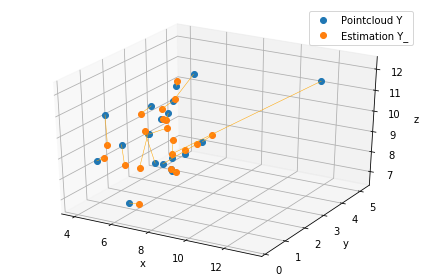

In [10]:
errors = []
T = mrob.SE3(np.zeros(6))
count = 0
prev_error = 0

while True:
    clear_output(wait=True)
    update_T(T, gradient(X,T,S))
    error = C_t_current_value(X,T,S)
    delta_error = prev_error - error
    errors.append(error)
    print(delta_error)
    print(error)
    if count >=2 and delta_error < 1e-4:
        break
    prev_error = error
    count += 1
    
plot_PC(Y,T,X)

Last error value: 50.25597856922007


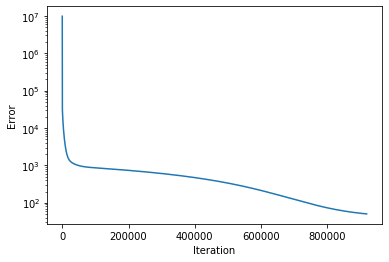

In [11]:
plt.semilogy(errors)
plt.xlabel('Iteration')
plt.ylabel('Error')

print('Last error value:', errors[-1])

In [12]:
T_ = T.T()

print('Estimated RBT:', T_, sep='\n')

Estimated RBT:
[[ 0.80434196 -0.53394831  0.26064     6.05102282]
 [ 0.5097554   0.3947647  -0.7644019   2.63346788]
 [ 0.30525963  0.74770317  0.58970885  9.12529601]
 [ 0.          0.          0.          1.        ]]


In [13]:
print('True RBT:', load_obj('T'), sep='\n')

True RBT:
[[ 0.7438831  -0.50134356  0.44191919  6.04302334]
 [ 0.65938053  0.44284877 -0.60753789  2.62663025]
 [ 0.10888184  0.74333008  0.66000389  9.21214559]
 [ 0.          0.          0.          1.        ]]


Results are not ideal, but convergence was reached. The evolution in the right direction of T is exist, maybe it is reasonable to continue optimization to decrease the error more.

### Task 2A

In [14]:
def gradient_hessian(X,T,S):
    R = T.transform_array(X.T) - Y.T
    grad = np.zeros(6)
    hessian = np.zeros((6,6))
    for i in range(20):            
        r = R[:,i]
        rot = skew(T.transform(X[i]))
        grad_i = np.hstack( (-rot , np.eye(3)))
        hessian = hessian + grad_i.T @ np.linalg.inv(S[i]) @ grad_i
        grad = grad + r.T @ np.linalg.inv(S[i]) @ grad_i
    return grad, hessian

In [15]:
T1 = mrob.SE3(np.zeros(6))

In [16]:
gradient_hessian(X,T1,S)

(array([   22076.38721072, -1215653.73313155, -5237119.62555151,
        -3075321.07552742,   -80008.2013959 ,    -6970.49691237]),
 array([[ 6.06026325e+03,  6.12959459e+01, -9.18721902e+02,
          0.00000000e+00, -9.37723505e+03,  8.60701794e+02],
        [ 6.12959459e+01,  6.93795417e+04,  2.94183015e+05,
          1.72540817e+05,  0.00000000e+00,  5.37514432e+01],
        [-9.18721902e+02,  2.94183015e+05,  1.27392572e+06,
          7.41902355e+05,  2.51583802e+03,  0.00000000e+00],
        [ 0.00000000e+00,  1.72540817e+05,  7.41902355e+05,
          4.37036468e+05,  0.00000000e+00,  0.00000000e+00],
        [-9.37723505e+03,  0.00000000e+00,  2.51583802e+03,
          0.00000000e+00,  2.35034249e+04,  0.00000000e+00],
        [ 8.60701794e+02,  5.37514432e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  6.84847794e+02]]))

### Task 2B

In [17]:
def update_T1(T, grad, hessian):
    alpha = 1
    T.update_lhs(- alpha * np.linalg.inv(hessian) @ grad)

9
-1.7763568394002505e-14
21.961869332803605


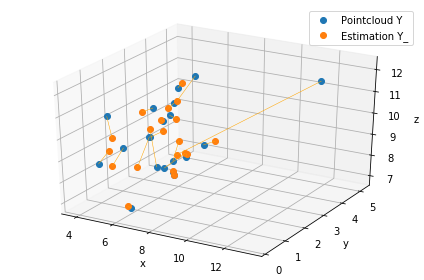

In [18]:
errors1 = []
T1 = mrob.SE3(np.zeros(6))
count = 0
prev_error = 0

while True:
    count += 1
    clear_output(wait=True)
    grad, hess = gradient_hessian(X, T1, S)
    update_T1(T1, grad, hess)
    error = C_t_current_value(X,T1,S)
    delta_error = prev_error - error
    errors1.append(error)
    print(count)
    print(delta_error)
    print(error)
    if count >=2 and delta_error < 1e-20:
        break
    prev_error = error
    
plot_PC(Y,T1,X)

Last error value: 21.961869332803605


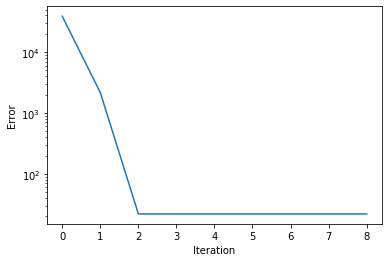

In [19]:
plt.semilogy(errors1)
plt.xlabel('Iteration')
plt.ylabel('Error')
print('Last error value:', errors1[-1])

In [20]:
T_ = T1.T()

print('Estimated RBT using GN:', T_, sep='\n')

Estimated RBT using GN:
[[ 0.74565773 -0.49892296  0.44166779  6.04601217]
 [ 0.65954763  0.4583125  -0.59577394  2.6571659 ]
 [ 0.09482342  0.73554438  0.67080771  9.16868547]
 [ 0.          0.          0.          1.        ]]


In [21]:
print('True RBT:', load_obj('T'), sep='\n')

True RBT:
[[ 0.7438831  -0.50134356  0.44191919  6.04302334]
 [ 0.65938053  0.44284877 -0.60753789  2.62663025]
 [ 0.10888184  0.74333008  0.66000389  9.21214559]
 [ 0.          0.          0.          1.        ]]


Amazing speed of convergence. Nine iterations using GN or more than 800k using GD. And moreover the final result after convergence using GN is much better and closer to desirable comparing to GD. I am quite admired by the difference in perfomances between these two methods, but it is pretty natural result since GN method takes into account the second derivative (hessian) and due to this optimize in more optimal way.